In [1]:
import pathlib

# umap analysis of treatment groups
# using warnings to ignore the deprecation warnings upon importing umap and numba
# these are annoying and not useful for the analysis output
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

# post hoc test for 'VEGF-C [NSU]' column using Tukey's HSD test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaPendingDeprecationWarning)

In [2]:
# Parameters
cell_type = "SHSY5Y"

In [3]:
# set the path to the data
data_dir = pathlib.Path(f"../data/{cell_type}_preprocessed_sc_norm.parquet")

# read in the data
data = pd.read_parquet(data_dir)

In [4]:
# subsample
print(data.shape)


if len(data) > 5000:
    df = data.sample(n=5000, random_state=0)
    del data
else:
    pass

print(df.shape)

(597902, 1276)
(5000, 1276)


In [5]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df.columns[df.columns.str.contains("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df[df_metadata]
df_values = df.drop(columns=df_metadata)

In [6]:
split_df = df_values.columns.str.split("_", expand=True).to_list()
split_df = pd.DataFrame(split_df)

In [7]:
# get each column name and split by the delimiter "_" to get the metadata category
# and the metadata value
split_df = df_values.columns.str.split("_", expand=True).to_list()

# make into a dataframe
split_df = pd.DataFrame(split_df)
split_df["feature"] = df_values.columns

# rename the columns
split_df.columns = [
    "compartment",
    "feature_group",
    "measurement",
    "channel",
    "parameter1",
    "parameter2",
    "parameter3",
    "features",
]

In [8]:
# Define the recoding dictionary
recode_dict = {
    "CorrDNA": "nuclei",
    "CorrMito": "Mito",
    "CorrER": "ER",
    "CorrGasdermin": "gasdermin",
    "CorrPM": "PM",
}

# Perform the recoding using replace() and fillna() methods
split_df["channel_learned"] = split_df["channel"].replace(recode_dict)
split_df["channel_learned"] = split_df["channel_learned"].fillna("other")

In [9]:
# split the df into 5 dataframes based on the channel_learned column
df_nuclei = split_df[split_df["channel_learned"] == "nuclei"].set_index("features")
df_mito = split_df[split_df["channel_learned"] == "Mito"].set_index("features")
df_ER = split_df[split_df["channel_learned"] == "ER"].set_index("features")
df_gasdermin = split_df[split_df["channel_learned"] == "gasdermin"].set_index(
    "features"
)
df_PM = split_df[split_df["channel_learned"] == "PM"].set_index("features")

In [10]:
# based on indexes get the metadata nd values for each channel
# df_nuclei_values
df_nuclei_values = df_values[df_nuclei.index]
# get values from a df via its index
df_nuclei_descriptive = df_descriptive.loc[df_nuclei_values.index.to_list()]
df_nuclei_descriptive.loc[:, "Metadata_compartment"] = "nuclei"

# df_mito_values
df_mito_values = df_values[df_mito.index]
df_mito_descriptive = df_descriptive.loc[df_mito_values.index.to_list()]
df_mito_descriptive.loc[:, "Metadata_compartment"] = "Mito"

# df_ER_values
df_ER_values = df_values[df_ER.index]
df_ER_descriptive = df_descriptive.loc[df_ER_values.index.to_list()]
df_ER_descriptive.loc[:, "Metadata_compartment"] = "ER"

# df_gasdermin_values
df_gasdermin_values = df_values[df_gasdermin.index]
df_gasdermin_descriptive = df_descriptive.loc[df_gasdermin_values.index.to_list()]
df_gasdermin_descriptive.loc[:, "Metadata_compartment"] = "gasdermin"

# df_PM_values
df_PM_values = df_values[df_PM.index]
df_PM_descriptive = df_descriptive.loc[df_PM_values.index.to_list()]
df_PM_descriptive.loc[:, "Metadata_compartment"] = "PM"

In [11]:
dictionary_of_channels = {
    "Nuclei": [df_nuclei_values, df_nuclei_descriptive],
    "Mito": [df_mito_values, df_mito_descriptive],
    "ER": [df_ER_values, df_ER_descriptive],
    "gasdermin": [df_gasdermin_values, df_gasdermin_descriptive],
    "PM": [df_PM_values, df_PM_descriptive],
}

In [12]:
# set umap parameters
umap_params = umap.UMAP(
    n_components=2,
    spread=1.1,
    init="random",
    random_state=0,
)

In [13]:
final_df = pd.DataFrame()

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


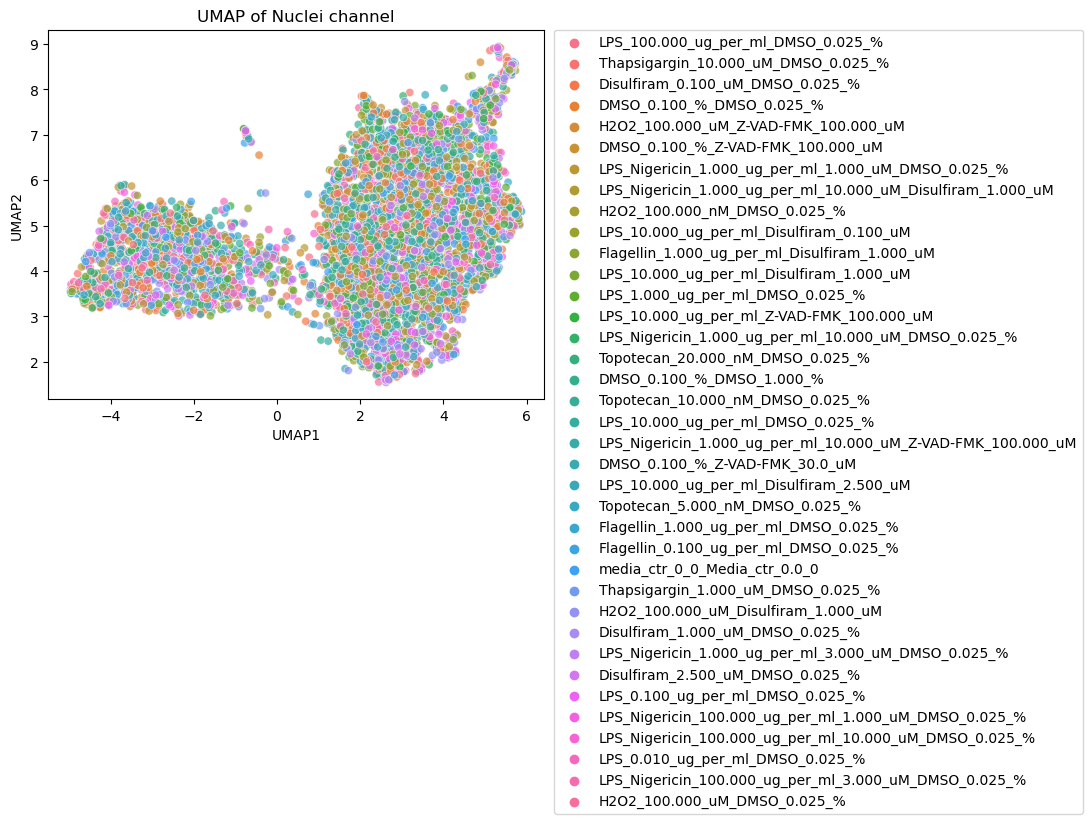

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


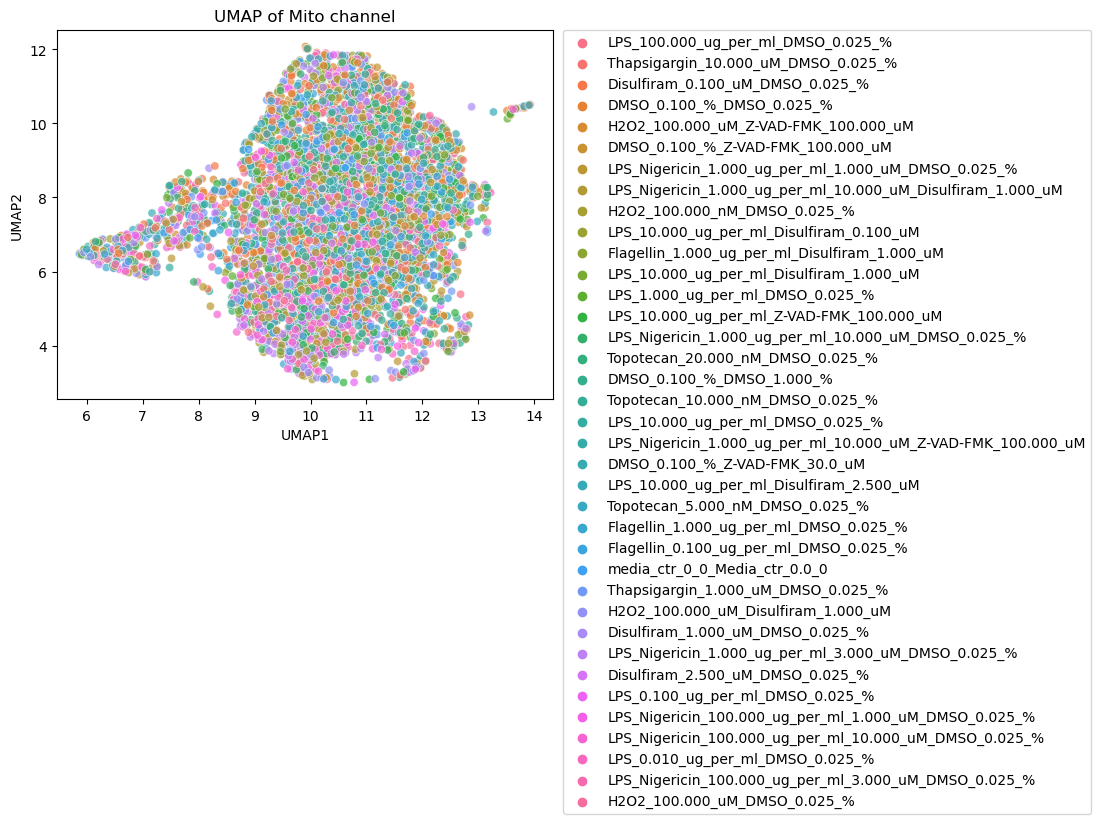

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


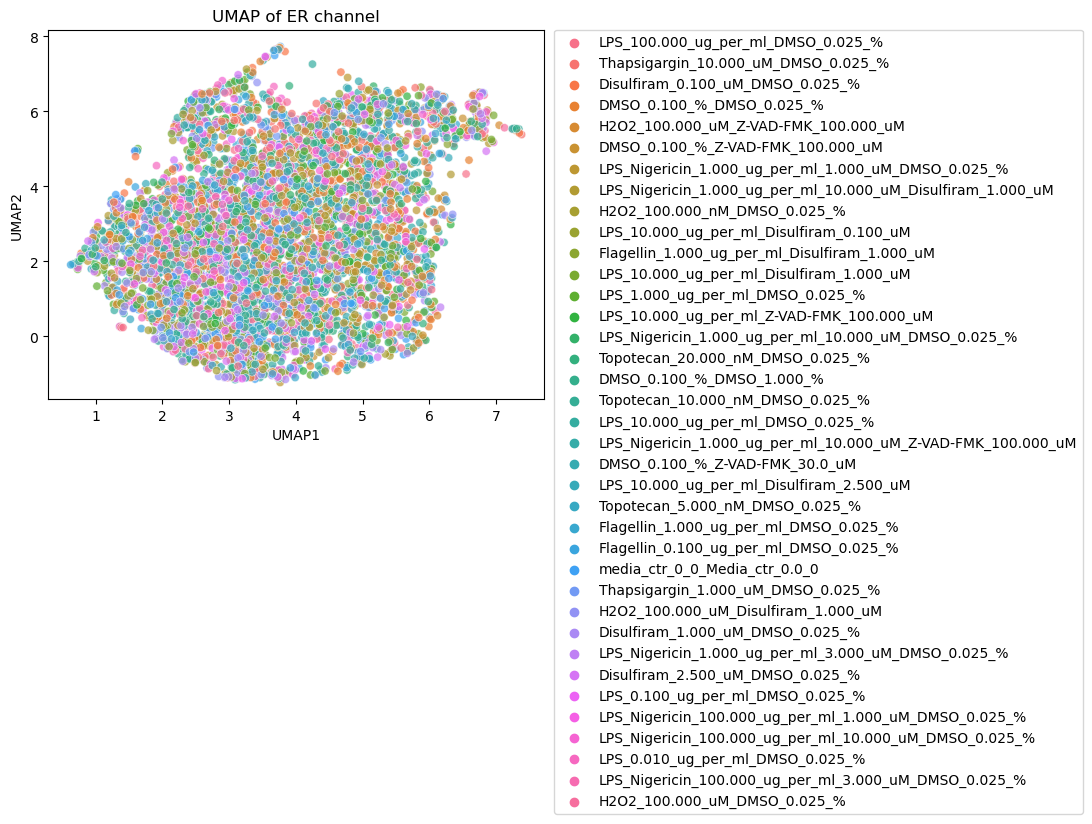

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


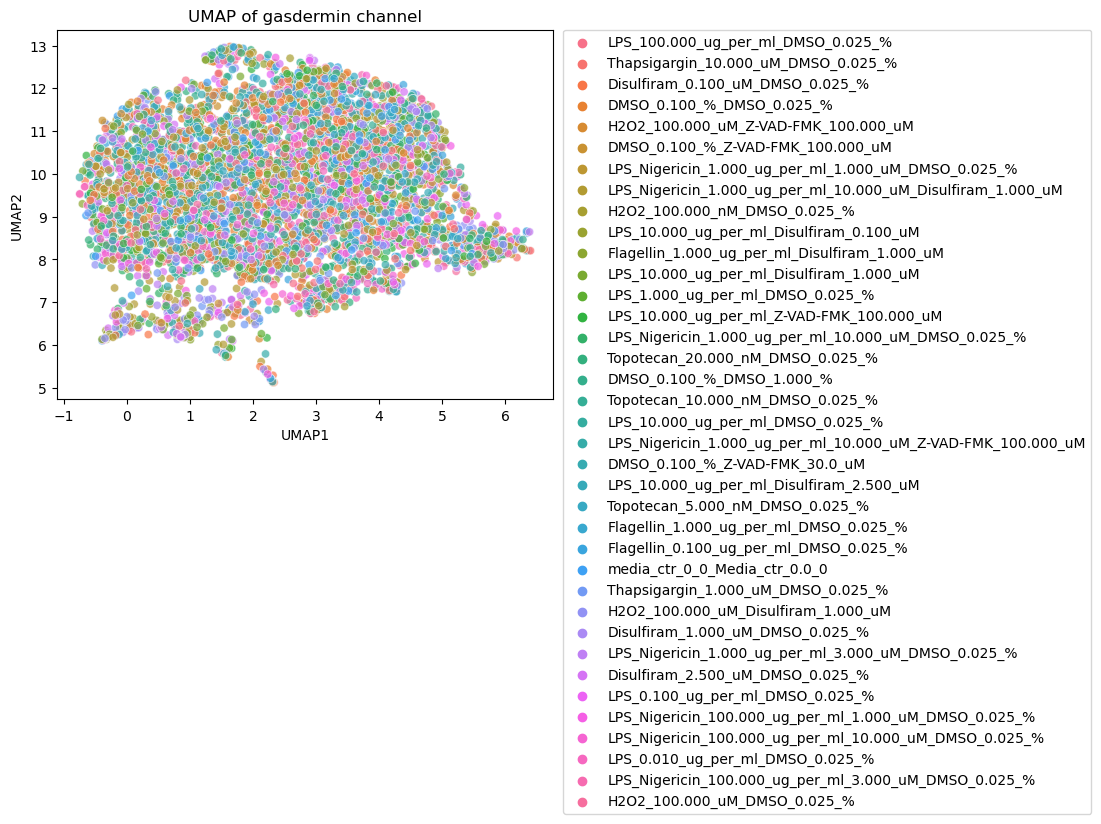

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


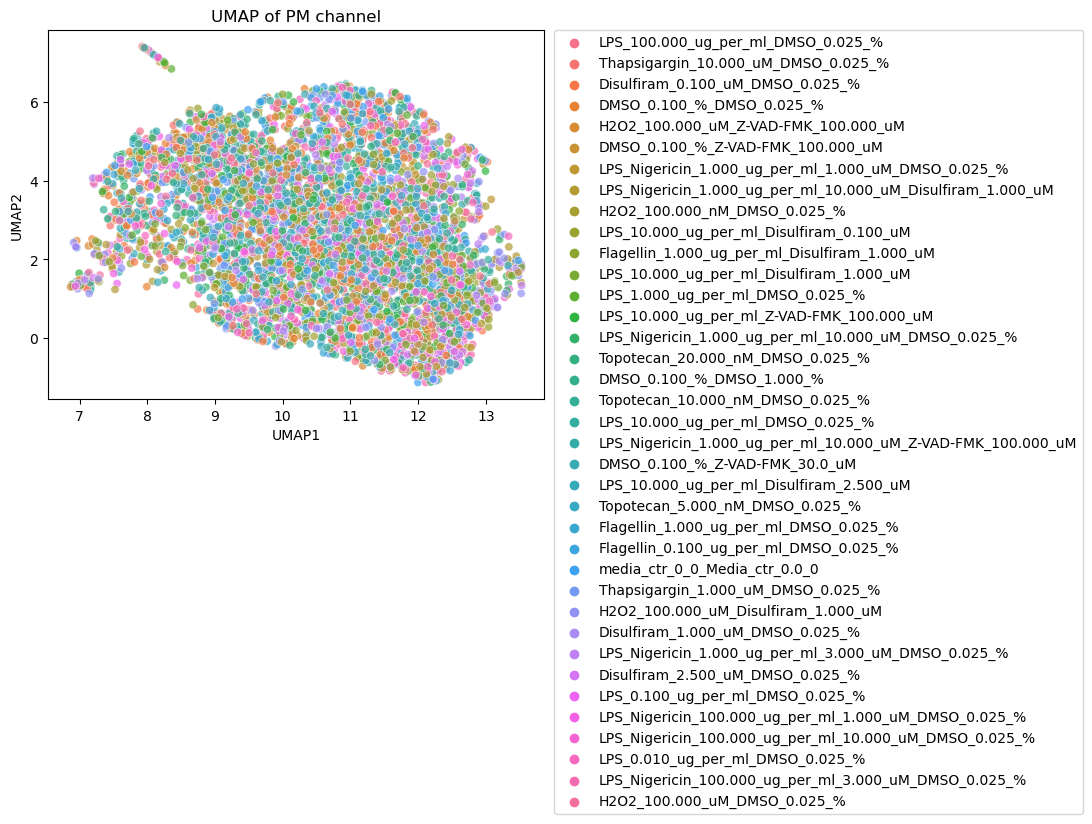

In [14]:
for channel in dictionary_of_channels:
    df_values = dictionary_of_channels[channel][0]
    df_descriptive = dictionary_of_channels[channel][1]
    umap_2d = umap_params.fit_transform(df_values)

    # new dataframe for each channel
    df_umap_values = pd.DataFrame(
        {
            "UMAP1": umap_2d[:, 0],
            "UMAP2": umap_2d[:, 1],
            "Treatment": df_descriptive["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"],
        }
    )
    final_df = pd.concat([final_df, df_umap_values], axis=0)

    # Figure Showing umap of Clusters vs Treatment
    sns.scatterplot(
        data=df_umap_values,
        x="UMAP1",
        y="UMAP2",
        hue="Treatment",
        legend="full",
        alpha=0.7,
    )
    plt.title("Visualized on umap")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    # plt.tight_layout()
    plt.title(f"""UMAP of {channel} channel""")
    # set save path for figure
    save_path = pathlib.Path(f"./Figures/umap_plate2/{cell_type}")
    save_path.mkdir(exist_ok=True, parents=True)
    plt.savefig(f"{save_path}/{channel}.png", bbox_inches="tight")
    plt.show()

In [15]:
final_df

,UMAP1,UMAP2,Treatment
427990,5.170089,4.492142,LPS_100.000_ug_per_ml_DMSO_0.025_%
69541,-1.925175,3.361497,Thapsigargin_10.000_uM_DMSO_0.025_%
182534,-2.426080,3.505802,Disulfiram_0.100_uM_DMSO_0.025_%
343794,-1.118660,5.054689,DMSO_0.100_%_DMSO_0.025_%
553657,-0.394956,4.183066,H2O2_100.000_uM_Z-VAD-FMK_100.000_uM
...,...,...,...
330715,8.973460,2.559488,DMSO_0.100_%_Z-VAD-FMK_30.0_uM
344392,11.012770,1.477625,DMSO_0.100_%_DMSO_0.025_%
189463,8.738603,1.509295,Disulfiram_1.000_uM_DMSO_0.025_%
361283,11.496161,1.511055,Topotecan_20.000_nM_DMSO_0.025_%


In [16]:
# write the final_df to a parquet file
outpath = pathlib.Path(f"./results/umap_per_channel_all_treatments.parquet")
# make a directory if it doesn't exist
outpath.parent.mkdir(exist_ok=True, parents=True)
final_df.to_parquet(outpath)